# Homework 4 - Applied Machine Learning

## TASK 1 - Classification

### 1A: Pre-processing

In [1]:
import pandas as pd                                     
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from  numpy.core.defchararray import split
from sklearn.preprocessing import robust_scale
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
#Load the data into a dataframe
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

The given dataset has 28 attributes for each dyad.

In [3]:
print(df.columns.shape)
print(df.columns)

(28,)
Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')


Our labels will be average of the columns 'rater 1' and 'rater 2', hence let's check their range

In [4]:
#Printing max and min values in rater 1 and rater 2
print('Minimum rating given by rater 1 is - ',df.rater1.min())
print('Maximum rating given by rater 1 is - ',df.rater1.max())
print('Minimum rating given by rater 2 is - ',df.rater2.min())
print('Maximum rating given by rater 2 is - ',df.rater2.max())

Minimum rating given by rater 1 is -  0.0
Maximum rating given by rater 1 is -  1.0
Minimum rating given by rater 2 is -  0.0
Maximum rating given by rater 2 is -  1.0


In [5]:
print('Number of missing values in rater 1 column - ',np.sum(df.rater2.isnull()))
print('Number of missing values in rater 1 column - ',np.sum(df.rater2.isnull()))
check=[df.rater1.isnull()] or [df.rater2.isnull()]
print('Number of entries where either of rater 1 or rater 2 has missing values - ',np.sum(check))

Number of missing values in rater 1 column -  21407
Number of missing values in rater 1 column -  21407
Number of entries where either of rater 1 or rater 2 has missing values -  21407


From above analysis we can say for all the dyad entries - either both of the rater values are missing or both are present

Also let's check the number of unique values and number of missing values in a given column (to have an idea what dropna might do)

In [6]:
#Printing the number of unique values in a given column
for col in df.columns:
    print(col,len(df[col].unique()))

playerShort 2053
player 2034
club 118
leagueCountry 4
birthday 1726
height 44
weight 46
position 13
games 45
victories 29
ties 15
defeats 19
goals 22
yellowCards 15
yellowReds 4
redCards 3
photoID 1586
rater1 6
rater2 6
refNum 3147
refCountry 161
Alpha_3 161
meanIAT 155
nIAT 130
seIAT 155
meanExp 150
nExp 137
seExp 155


In [7]:
#Printing the number of missing values in a given column
for col in df.columns:
    print(col,sum(df[col].isnull()))

playerShort 0
player 0
club 0
leagueCountry 0
birthday 0
height 263
weight 2243
position 17726
games 0
victories 0
ties 0
defeats 0
goals 0
yellowCards 0
yellowReds 0
redCards 0
photoID 21407
rater1 21407
rater2 21407
refNum 0
refCountry 0
Alpha_3 1
meanIAT 163
nIAT 163
seIAT 163
meanExp 163
nExp 163
seExp 163


***Preparing the data matrix X***:

Firstly we drop entries that have any missing values, this does not seem to be a big fraction of the data we have.

In order to perform the classification task, we first group the given dataframe by players. Further we need a way to aggregate the data of different referee interactions for a given player, this is described below. 

1. We can get rid of the following attributes of the referees in the process of aggregating by players - 'refNum' and 'refCountry'. 
2. For attributes of 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds' and 'redCards', we take the sum over all the dyads for a given player.
3. For the 'meanIAT' and 'meanExp' attributes we decide to take their average across different dyads for a given player. We calculate the new 'stdIAT' and 'stdExp' using these values (new 'stdIAT' is defined to be the standard deviation of the 'meanIAT's that are averaged to form the new 'meanIAT' and the new 'stdExp' is defined to be the standard deviation of the 'meanExp's that are averaged to form the new 'meanExp').
4. Drop the attributes - 'nIAT', 'nExp', 'seIAT', 'seExp', since we compute the new standard deviations as per 3
5. We also decide to drop the following attributes which are specific to the player in the dyads, since we assume these are not relevant to the classification - 'playerShort', 'player', 'birthday' and 'photoID'. 

Lastly, we do not include the 'rater1' and 'rater2' attributes in our data matrix, since these will form the labels that are to be predicted.

***Preparing the labels y***:


We simply take the average of 'rater1' and 'rater2' values - this leads to 8 classes between 0 and 1. 

In [8]:
#Printing the number of unique players in the dataset
len(df.player.unique())

2034

In [9]:
df = df.dropna()

# Aggregating the dyads by player attribute
data_grouped_by_player = df.groupby("player")

# Initializing empty numpy arrays to store the data and the labels
X = np.empty((0,17))
y = np.empty((0,1))


player_set = [data_grouped_by_player.get_group(x) for x in data_grouped_by_player.groups]

for player in player_set:

    description = player.iloc[0]
    arr = np.array([description["club"], description["leagueCountry"], description['height'], 
                    description['weight'], description['position'], 
                    player['games'].sum(), player['victories'].sum(), player['ties'].sum(), 
                    player['defeats'].sum(), player['goals'].sum(), player['yellowCards'].sum(),
                    player['yellowReds'].sum(), player['redCards'].sum(), player['meanIAT'].mean(), 
                    player['meanExp'].mean(), np.nanstd(player['meanIAT']), np.nanstd(player['meanExp']) ])

    X = np.vstack((X,arr))
    y = np.vstack((y, (description["rater1"]+description["rater2"])/2 ))

In the first step we perform df.dropna() without caring about the subset argument. There could be a possibility that the we drop the entries for which there are missing values only for the features we don't even care about for classification and this would be a loss of relevant data. We however investigate and confirm that this is not the case. The features we drop are - 
'playerShort' - missing values - 0
'player' - missing values - 0
'birthday'- missing values - 0
'refNum'- missing values - 0
'refCountry'- missing values - 0
'nIAT'- missing values - 163
'seIAT'- missing values - 163
'nExp'- missing values - 163
'seExp'- missing values - 163
For the first 5 attributes listed here, the argument above holds. For the last 4 attributes we find that the number 163 is also equal to the number of missing values for 'meanIAT' and 'meanExp', hence we would have dropped them anyway since we need these values to build the data matrix X.

With the pre-processing explained above, we obtain data matrix X and label y, let's print what the instances look like now - 

In [10]:
print(X.shape)
print(X[0].shape)
print(X[0])
print(y)
print(y.shape)

(1406, 17)
(17,)
['SC Freiburg' 'Germany' '184.0' '85.0' 'Defensive Midfielder' '117' '38'
 '34' '45' '9' '21' '2' '2' '0.34959700846353076' '0.5015003012559662'
 '0.0278256643399' '0.271196118583']
[[ 0.75 ]
 [ 0.25 ]
 [ 0.75 ]
 ..., 
 [ 0.   ]
 [ 0.375]
 [ 0.125]]
(1406, 1)


***Some more work on the array y of labels:***


We decide to turn this multiclass problem to binary classification. Hence we break the set into two classes - class A: with values less than 0.5 and class B: with values greater than 0.5, we decide to ***drop the candidates with target values equal to 0.5*** (this is about 10% of the data) in order to simplify the classification. 


In [11]:
print(y)
print('no of instances (players) with average rating equal to 0.5:',len(y[y==0.5]))
print('no of instances (players) with average rating less than 0.5:',len(y[y<0.5]))
print('no of instances (players) with average rating greater than 0.5:',len(y[y>0.5]))


[[ 0.75 ]
 [ 0.25 ]
 [ 0.75 ]
 ..., 
 [ 0.   ]
 [ 0.375]
 [ 0.125]]
no of instances (players) with average rating equal to 0.5: 103
no of instances (players) with average rating less than 0.5: 1078
no of instances (players) with average rating greater than 0.5: 225


In [12]:
y[y<0.5] = 0
y[y>0.5] = 1

In [13]:
#Dropping the players with ratings equal to 0.5 from the data

X = X[y.ravel() != 0.5]
y = y[y.ravel() != 0.5]
print(X.shape, y.shape)

(1303, 17) (1303, 1)


***Some more preprocessing on the data matrix X (one-hot vector encoding of categorical values)***:

We now have the required features in the numpy 2d array X, however some of them happen to be categorical and not numerical, and sklearn Random Forest Classifier does not accept categorical values. 

Hence we need to encode these attributes into onehot vectors. The sklearn one-hot encoder does not accept strings, hence we first turn the categorical features in strings to numerical values using Label Encoder and then turn these numerical values to one hot vectors using OneHotEncoder. We then append these one-hot vectors to our data-matrix X to get the X_final matrix that we can feed to the Random Forests Classifier, where we consider each component of the one-hot vector as a new attribute for our entries in X.

To be clear about the dimensions - currently the data matrix X has 17 columns, 3 of which are categorical, these 3 will be encoded using one-hot vectors. Let's see their encoding details:


1. attribute given by 0th column - X[:,0] : 'club'          - 90 unique values, therefore a one-hot vector of length 90
2. attribute given by 1st column - X[:,1] : 'leagueCountry' - 4 unique values, therefore a one-hot vector of length 4
3. attribute given by 4th column - X[:,4] : 'position'      - 12 unique values, therefore a one-hot vector of length 12

Thus our X_final matrix would have 17 - 3 + (90 + 4 + 12) = 120 columns. That's a lot, most of these will have just zero values!


In [14]:
print('Number of unique values in column 0 (club)         :' ,np.unique(X[:,0]).shape[0])
print('Number of unique values in column 1 (leagueCountry):' ,np.unique(X[:,1]).shape[0])
print('Number of unique values in column 4 (position)     :' ,np.unique(X[:,4]).shape[0])

Number of unique values in column 0 (club)         : 90
Number of unique values in column 1 (leagueCountry): 4
Number of unique values in column 4 (position)     : 12


In [15]:
N=X.shape[0]

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

X_one_hot=np.empty((N,0))

# Array with index for categorical columns
categorical_list = [0,1,4]

for i in categorical_list:
    X_pre_encode = X[:,i:i+1]

    le = preprocessing.LabelEncoder()
    # Fitting and transforming using the label encoder 
    # over the column of categorical values (turning them to numbers)
    le.fit(X_pre_encode)
    ans = le.transform(X_pre_encode)
    
    enc = OneHotEncoder()
    # Fitting and transforming using the One-hot encoder 
    # over the label encoded column of categorical values (turning them to one-hot vectors)
    enc.fit(ans)
    ans2 = enc.transform(ans).toarray()
    print('attribute in column', i, 'encoded using vector of length - ',ans2.shape[1])
    X_one_hot = np.hstack((X_one_hot,ans2))
    
    

attribute in column 0 encoded using vector of length -  90
attribute in column 1 encoded using vector of length -  4
attribute in column 4 encoded using vector of length -  12


/Users/akhileshgotmare/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/akhileshgotmare/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/akhileshgotmare/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
print(X_one_hot.shape) #dimensions of the one-hot vector matrix to be appended to the original data matrix

(1303, 106)


In [17]:
#Deleting the categorical columns 0,1 and 4 (club, league country and position respectively)

X_final = np.delete(X, categorical_list, 1) 
print(X_final[0])

#Appending the one-hot vectors to the data matrix

X_final = np.hstack((X_final,X_one_hot)) 
print(X_final[0])

['184.0' '85.0' '117' '38' '34' '45' '9' '21' '2' '2' '0.34959700846353076'
 '0.5015003012559662' '0.0278256643399' '0.271196118583']
['184.0' '85.0' '117' '38' '34' '45' '9' '21' '2' '2' '0.34959700846353076'
 '0.5015003012559662' '0.0278256643399' '0.271196118583' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '1.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '1.0' '0.0' '0.0' '0.0' '0.0' '0.0' '1.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0']


In [18]:
print(X_final.shape, y.shape)

(1303, 120) (1303, 1)


X_final has 120 columns, let's state clearly what are they ( | column index - attribute name | )  --> 

 
| 0 - height | 1 -  weight | 2 - total games | 3 - total victories | 4 - total ties | 5 - total defeats | 6 - total goals | 7 - total yellowCards | 

| 8 - total yellowReds | 9 - total redCards | 10 - meanIAT(new) | 11 - meanExp(new) | 12 - stdIAT | 13 - stdExp |

| 14 - 103 Club one-hot vector |104 - 107 leagueCountry one-hot vector | 108 - 119 position one-hot vector



In [19]:
y

array([[ 1.],
       [ 0.],
       [ 1.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [20]:
sum(y==1)

array([225])

In [21]:
print((y[y==1]).shape[0])
print((y[y==0]).shape[0])

225
1078


In [22]:
a = len(y[y==1])
b = len(y[y==0])

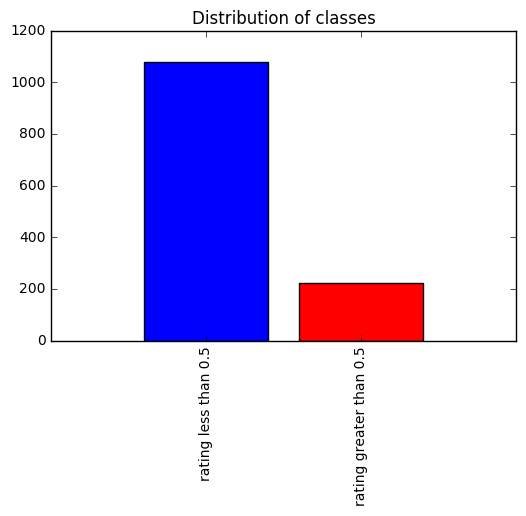

In [23]:
plt.figure()
plt.title("Distribution of classes")
plt.bar([0,1], [b,a], color="br",  align="center")
plt.xticks([0,1], ['rating less than 0.5','rating greater than 0.5'],rotation='vertical')
plt.xlim([-1, 2])
plt.show()

As is evident from the chart above, the data is quite imbalanced to be fed to the classifier. Possible methods to deal with this problem include - 

1. Undersampling of the majority class (eg. chosing 225 (= size of minority class) random samples out of the 1078 majority instances
2. SMOTE (synthetic minority oversampling technique) applied to the minority class to creat synthetic instances

but for the scope of this homework we ignore this problem and proceed with the imbalanced dataset.
As the last stage of the pre-processing, we perform the standardization operation on the data matrix X_final (x := (x-$\mu$) / $\sigma$).

In [24]:
X_final_ex2 = X_final
from sklearn import preprocessing
X_final = preprocessing.StandardScaler().fit_transform(X_final)

/Users/akhileshgotmare/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/akhileshgotmare/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### 1B: Training random forest classifier

Here we train the Random Forests Classifier with default values of parameters. We split the data obtained from the pre-processing described above into training and test set (90:10 ratio), and obtain a training accuracy of about 98% and test accuracy of about 83%.

In [25]:
X_final.shape

(1303, 120)

In [26]:
y.shape

(1303, 1)

In [27]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.1, random_state=4)
print(X_train.shape, X_test.shape)

(1172, 120) (131, 120)


In [28]:
from sklearn import metrics
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train.ravel())
y_pred = rfc.predict(X_test)
print(metrics.accuracy_score(y_test.ravel(), y_pred))

0.839694656489


In [29]:
rfc.score(X_train,y_train.ravel())

0.98464163822525597

In [30]:
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred, labels=None)

array([[100,   3],
       [ 18,  10]])

In [31]:
from sklearn import metrics
print('Confusion matrix - ')
print(metrics.confusion_matrix(y_test, y_pred, labels=None))
print('Precision value - ',metrics.precision_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))
print('Recall value - ',metrics.recall_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))

Confusion matrix - 
[[100   3]
 [ 18  10]]
Precision value -  0.769230769231
Recall value -  0.357142857143


In [32]:
metrics.f1_score(y_test, y_pred, average='macro')

/Users/akhileshgotmare/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


0.48780487804878053

As is clear above, the classifier does good precision-wise but is not good with the recall, the imbalance in the data seems to be the reason for the poor recall. The recall being poor means the classifier is poor at identifying the positive cases (minority class) which happen to be the dark skinned players in this case. Similarly, the f1_score can have a best value of 1 and turns out to be 0.49 here.

### 1C: Showing how different parameters passed to classifier affect overfitting:

We focus our attention to the following four parameters passed to the classifier (description from sklearn documentation):

        1. n_estimators  : The number of trees in the forest.

        2. max_depth     : The maximum depth of the tree

        3. max_features  : The number of features to consider when looking for the best split

        4. min_samples_leaf : The minimum number of samples required to be at a leaf node


In this step we intend to observe the effect of varying parameters of the classifier on its' performance (both test and training scores). We do this by randomly removing 10% of our data (test set) and training our classifier on the remaining 90% (training set).

In the implementation below we run a for loop over each parameter while keeping the other parameters to default values and train the classifier using training set and evaluate it on both the sets.

In [33]:
X_final.shape

(1303, 120)

In [34]:
y.shape

(1303, 1)

In [35]:
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn import metrics


X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.1, random_state=4)

# Initializing empty arrays to score test and training accuracy scores of the classifier
# for each of the hyper-parameter we intend to change (4 of them)
# hor_axis is to store the values that the hyper-parameter takes corresponding to the scores in the 
# test_scores and train_scores array

test_scores = [[],[],[],[]]
train_scores = [[],[],[],[]]
hor_axis = [[],[],[],[]]


# Defining the range in which each hyper-parameter will be varied
range_=[range(10,101,5), range(10,101,5), range(2,100,5), range(1,120,1)]
param_name = ['no. of estimators', 'maximum depth', 'minimum samples leaf', 'maximum features']

# 0 - n_estim, 1 - max_depth, 2 - min_samples_leaf, 3 - max_features
    

for parameter in [0,1,2,3]:

    print('parameter being varied - ' , parameter, param_name[parameter] )
   
    [n_est, max_d, min_sam, max_feat] = [10, None, 1, 'auto'] #Setting the others to defaults
   
   
    for param_val in range_[parameter]:
        if parameter == 0:
            n_est = param_val
        if parameter == 1:
            max_d = param_val
        if parameter == 2:
            min_sam = param_val
        if parameter == 3:
            max_feat = param_val
       
        rfc = RandomForestClassifier(n_estimators = n_est, max_depth = max_d, 
                                    min_samples_leaf = min_sam, max_features = max_feat)
        rfc.fit(X_train,y_train.ravel())
        ans1 = rfc.score(X_train,y_train.ravel())
        train_scores[parameter].append(ans1)

        y_pred = rfc.predict(X_test)
        ans2 = metrics.accuracy_score(y_test.ravel(), y_pred)
        test_scores[parameter].append(ans2)
        hor_axis[parameter].append(param_val)

    

parameter being varied -  0 no. of estimators
parameter being varied -  1 maximum depth
parameter being varied -  2 minimum samples leaf
parameter being varied -  3 maximum features


In [36]:
# Let's see the numbers we have obtained!
for i in [0,1,2,3]:
    print(param_name[i])
    for j in range(len(train_scores[i])):
        print (range_[i][j], " - training: ", train_scores[i][j], " test: ", test_scores[i][j])

no. of estimators
10  - training:  0.9795221843  test:  0.81679389313
15  - training:  0.994880546075  test:  0.832061068702
20  - training:  0.993174061433  test:  0.824427480916
25  - training:  0.996587030717  test:  0.824427480916
30  - training:  0.999146757679  test:  0.832061068702
35  - training:  1.0  test:  0.839694656489
40  - training:  0.999146757679  test:  0.824427480916
45  - training:  1.0  test:  0.832061068702
50  - training:  0.999146757679  test:  0.832061068702
55  - training:  1.0  test:  0.809160305344
60  - training:  0.999146757679  test:  0.824427480916
65  - training:  1.0  test:  0.824427480916
70  - training:  1.0  test:  0.839694656489
75  - training:  1.0  test:  0.824427480916
80  - training:  1.0  test:  0.824427480916
85  - training:  1.0  test:  0.81679389313
90  - training:  1.0  test:  0.832061068702
95  - training:  1.0  test:  0.824427480916
100  - training:  1.0  test:  0.824427480916
maximum depth
10  - training:  0.909556313993  test:  0.81679

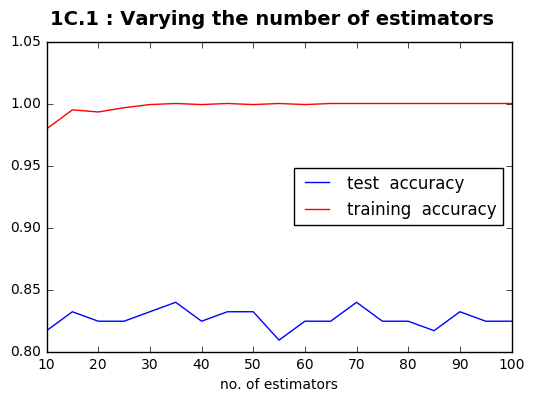

In [37]:
parameter = 0

plt.plot(hor_axis[parameter], test_scores[parameter],'-b',label='test  accuracy')
plt.plot(hor_axis[parameter], train_scores[parameter],'-r',label='training  accuracy')
plt.legend(loc='best')

plt.xlabel(param_name[parameter])
plt.suptitle('1C.1 : Varying the number of estimators', fontsize=14, fontweight='bold')

plt.show()


In the plot above we vary the number of estimators from 10 (default) to 100 in steps of 5 and as can be seen from the plot above, an increase in test accuracy does not necessarily correspond to an increase in the test accuracy. In some regions an increase in the no of estimators (therefore increase in the complexity of the classifier) results in a fall in the test-data accuracy scores while the training accuracy is very close to 1. This is an instance of overfitting by the classifier on the training data.

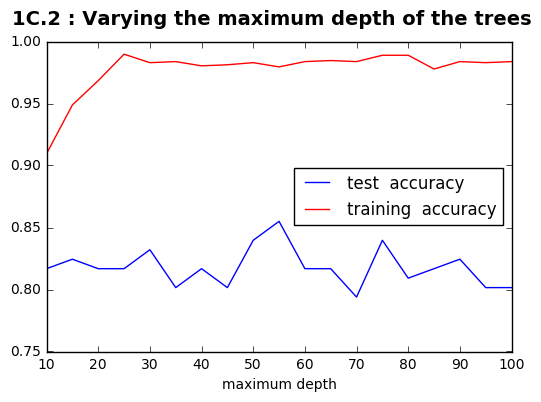

In [38]:
parameter = 1
plt.plot(hor_axis[parameter], test_scores[parameter],'-b',label='test  accuracy')
plt.plot(hor_axis[parameter], train_scores[parameter],'-r',label='training  accuracy')
plt.legend(loc='best')

plt.xlabel(param_name[parameter])
plt.suptitle('1C.2 : Varying the maximum depth of the trees', fontsize=14, fontweight='bold')
plt.show()


In the plot above we vary the maximum depth parameter from 10 to 100 in steps of 5. For small values of this parameter we see the training scores going up with the increase in complexity, which makes sense, because initially our trees are not deep. However, as we increase this parameter further, the trainng accuracy tends to one, while in some regions the test accuracy tends to decrease. This is also an instance of overfitting.


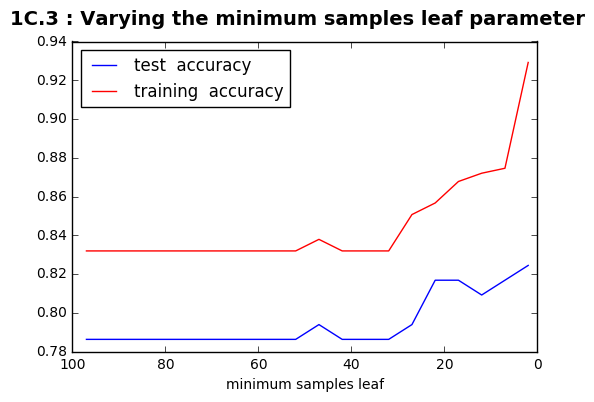

In [39]:
parameter = 2

plt.plot(hor_axis[parameter], test_scores[parameter],'-b',label='test  accuracy')
plt.plot(hor_axis[parameter], train_scores[parameter],'-r',label='training  accuracy')
plt.legend(loc='best')
plt.suptitle('1C.3 : Varying the minimum samples leaf parameter', fontsize=14, fontweight='bold')
plt.xlabel(param_name[parameter])
plt.gca().invert_xaxis()
plt.show()


We aren't sure if lesser values of this parameter relate to higher complexity of the classifier. However the plots suggest the training accuracy (although a bit bumpy) increases to a high accuracy as the parameter value decreases towards zero. The test accuracy also increases along the x-axis however it does not necessarily improve at each step implying the potential overfitting towards lower values of the parameter.

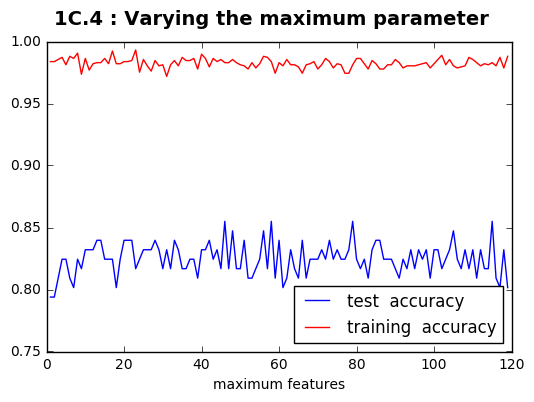

In [40]:
parameter = 3
plt.plot(hor_axis[parameter], test_scores[parameter],'-b',label='test  accuracy')
plt.plot(hor_axis[parameter], train_scores[parameter],'-r',label='training  accuracy')
plt.legend(loc='best')
plt.suptitle('1C.4 : Varying the maximum parameter', fontsize=14, fontweight='bold')
plt.xlabel(param_name[parameter])
plt.show()

In the plot above we vary the maximum features parameter. Therefore more and more of the 120 features are considered (in the order that they appear in the data matrix) along the horizontal axis. We can see that the training accuracy is pretty close to 1 however the test accuracy keeps oscillating around 0.8 - 0.85. It would not be perfect to consider this as overfitting due to the complexity of the model, since only one ordering of the features is considered here and different ordering of features could lead to different plots of training and test accuracies. The subsequent section (1E) on feature_importances covers this in more detail.

### 1D: Using cross-validation to mitigate overfitting and finding optimal parameters

In order to overcome the problem of overfitting and also to take care of the bias that a specific selection of test-train split can bring to our evaluation, we perform cross-validation. This would give us the optimal combination of hyper-parameters. We leave the maximum features and minimum samples leaf to default and try to tune the other 2 hyper-parameters - no of estimators and maximum depth of the tree 
 

In [41]:
# We leave the maximum features and minimum samples leaf to default and try to tune the other 2
# hyper-parameters - no of estimators and maximum depth of the tree 

from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics


# initializing the range in which each hyper-param will be varied

range_=[range(10,500,50), range(10,101,10)] 
param_name = ['no. of estimators', 'maximum depth']

# 0 - n_estim, 1 - max_depth, 2 - min_samples_leaf, 3 - max_features

# initializing arrays to store cross-validation scores and the corresponding hyper-parameters
# that will be varied

cross_val_scores = np.zeros( [ len(range_[0]) , len(range_[1]) ] )
param_no_of_trees =np.zeros( [ len(range_[0]) , len(range_[1]) ] ) 
param_max_depth = np.zeros( [ len(range_[0]) , len(range_[1]) ] )
ind1=0
ind2=0
for ind1,n_est in enumerate(range_[0]): 
    for ind2,max_d in enumerate(range_[1]):
        
        rfc = RandomForestClassifier(n_estimators = n_est, max_depth = max_d)
        result = cross_val_score(rfc, X_final, y.ravel(), cv=10, scoring='accuracy').mean()
        
        cross_val_scores[ind1, ind2] = result
        param_no_of_trees[ind1,ind2] = n_est
        param_max_depth[ind1,ind2]   = max_d
        print(ind1,ind2)
        
        

    

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9


In [50]:
print(np.argmax(cross_val_scores))
print(np.max(cross_val_scores))

12
0.872645536604


In [51]:
print(cross_val_scores[1,2],param_no_of_trees[1,2],param_max_depth[1,2])

0.872645536604 60.0 30.0


Using cross-validation we find the optimal set of hyper-parameters. In the cell above we performed grid-search on the a specific range of the 2 parameters - number of estimators (no of trees) in the forest and the maximum depth of the trees. For parameters num_estimators = 60
and max_depth=30 we obtain cross-validation accuracy close to 87.2%

### 1E: Inspecting $feature_importances_$ attribute

The feature_importances attribute will give us an idea as to how informative each feature is with respect to the classification task at our disposal.

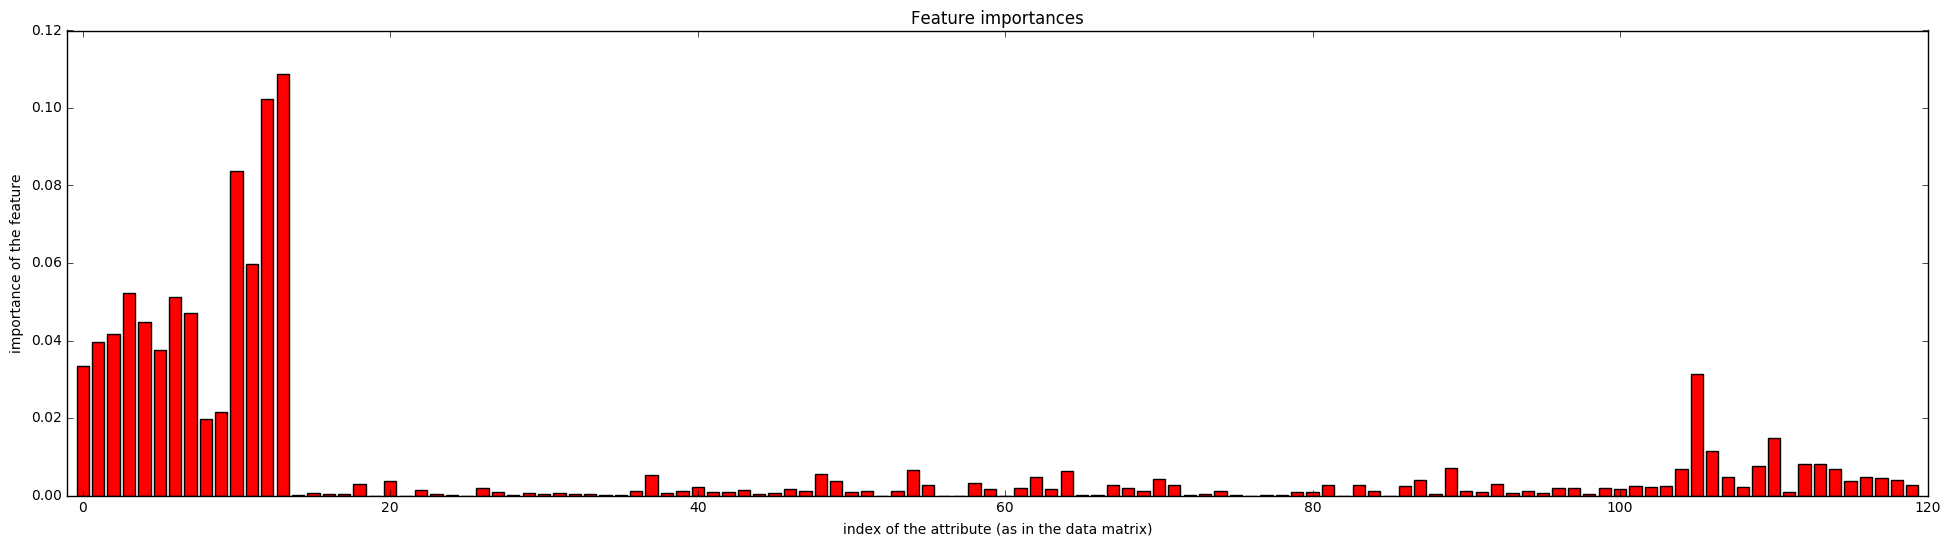

In [52]:
# Plot the feature importances of the forest

forest = RandomForestClassifier()
forest.fit(X_final,y.ravel())
importances = forest.feature_importances_

xlimit=120

# Re-sizing the plot for better understanding
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 24
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_final.shape[1]), importances,
       color="r",  align="center")
plt.xlabel('index of the attribute (as in the data matrix)')
plt.ylabel('importance of the feature')
plt.xlim([-1, xlimit])
plt.show()

The feature importances in the bar graph above are arranged in the same order as they appear in the data matrix - 
 
| 0 - height | 1 -  weight | 2 - total games | 3 - total victories | 4 - total ties | 5 - total defeats | 6 - total goals | 7 - total yellowCards | 

| 8 - total yellowReds | 9 - total redCards | 10 - meanIAT(new) | 11 - meanExp(new) | 12 - stdIAT | 13 - stdExp |

| 14 - 103 Club one-hot vector |104 - 107 leagueCountry one-hot vector | 108 - 119 position one-hot vector | 

As is evident from the histogram the first 14 features (column index 0 to 13) have significant feature importance values. Followed by them is the feature importance value of the position one-hot vector, this makes sense since some positions are more prone to getting cards from the referee. The feature with most importance turns out to be 'stdIAT'. In the cell below we present the 20 most powerful features in sorted order. Also the vectors from leagueCountry and Club seem to carry very little importance except for few values of the attribute leagueCountry.

The next bar graph presents these importance values in and ordered manner.

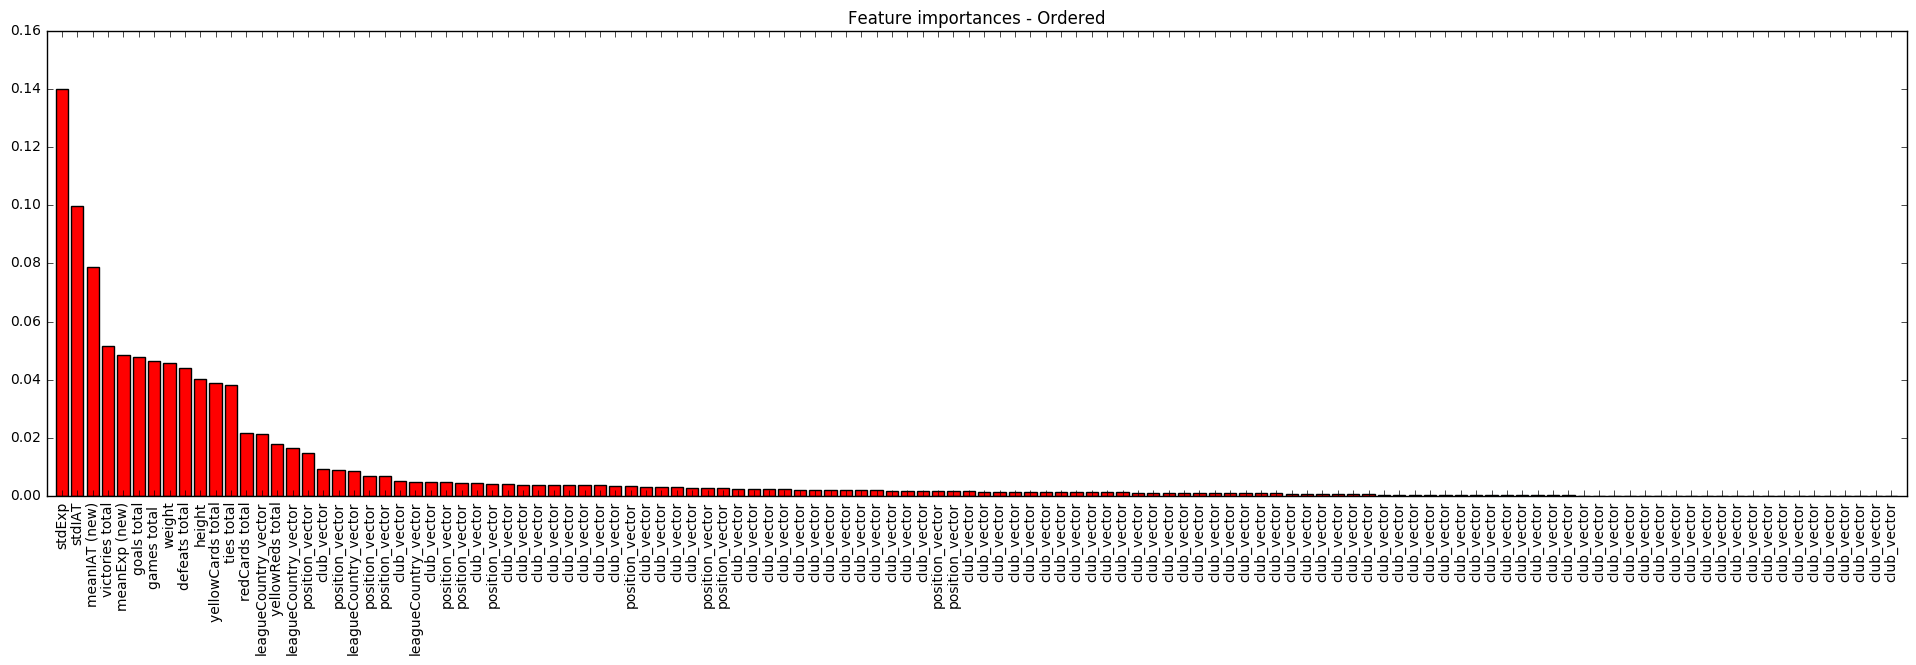

In [53]:
# Plot the feature importances of the forest

forest = RandomForestClassifier()
forest.fit(X_final,y.ravel())
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1] # sorting the importances and storing the sorted order of attribute indices


a = np.append(['height','weight','games total ','victories total','ties total','defeats total','goals total',
            'yellowCards total','yellowReds total','redCards total','meanIAT (new)','meanExp (new)',
            'stdIAT','stdExp'],np.repeat(['club_vector'],90)   )

b = np.append(a,np.repeat(['leagueCountry_vector'],4) )
c = np.append(b,np.repeat(['position_vector'],12))

feature_names = c

xlimit=120
plt.figure()
plt.title("Feature importances - Ordered")
plt.bar(range(X_final.shape[1]), importances[indices],
       color="r",  align="center")
plt.xticks(range(xlimit), feature_names[indices],rotation='vertical')
plt.xlim([-1, xlimit])
plt.show()

Let us have the sorted list of features as per their feature_importance values

In [54]:
print(feature_names[indices])

['stdExp' 'stdIAT' 'meanIAT (new)' 'victories total' 'meanExp (new)'
 'goals total' 'games total ' 'weight' 'defeats total' 'height'
 'yellowCards total' 'ties total' 'redCards total' 'leagueCountry_vector'
 'yellowReds total' 'leagueCountry_vector' 'position_vector' 'club_vector'
 'position_vector' 'leagueCountry_vector' 'position_vector'
 'position_vector' 'club_vector' 'leagueCountry_vector' 'club_vector'
 'position_vector' 'position_vector' 'club_vector' 'position_vector'
 'club_vector' 'club_vector' 'club_vector' 'club_vector' 'club_vector'
 'club_vector' 'club_vector' 'club_vector' 'position_vector' 'club_vector'
 'club_vector' 'club_vector' 'club_vector' 'position_vector'
 'position_vector' 'club_vector' 'club_vector' 'club_vector' 'club_vector'
 'club_vector' 'club_vector' 'club_vector' 'club_vector' 'club_vector'
 'club_vector' 'club_vector' 'club_vector' 'club_vector' 'position_vector'
 'position_vector' 'club_vector' 'club_vector' 'club_vector' 'club_vector'
 'club_vector' '

Next we ***drop the 116 least important features*** from the data matrix and train the classifier again using only the most important 14 features.

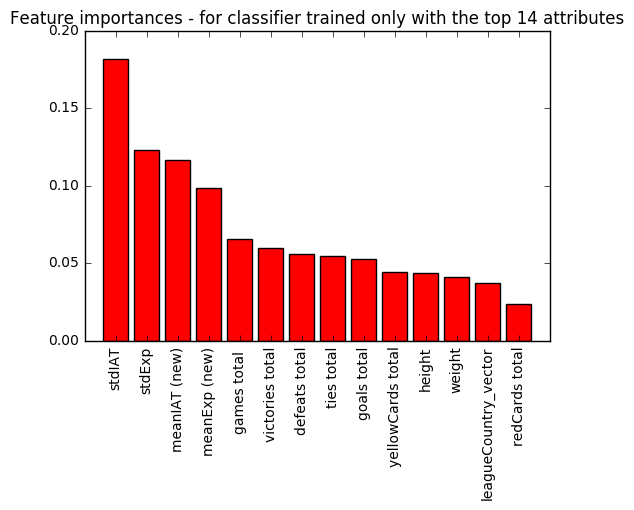

In [55]:
# Delete the 116 least important features
X = np.delete (X_final,indices[14:120],1) 
# these also need to be deleted from the feature_names since we'll use the feature names for plotting next
feature_names_new = np.delete(feature_names, indices[14:120],0)
# NOTE: indices array contains sorted feature indices according to feature importances (from previous cell)

xlimit=14

# Train with the modified data matrix X
forest = RandomForestClassifier()
forest.fit(X,y.ravel())
importances = forest.feature_importances_
indices_new = np.argsort(importances)[::-1]


# Re-sizing the plot for better understanding
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



plt.figure()
plt.title("Feature importances - for classifier trained only with the top 14 attributes")
plt.bar(range(X.shape[1]), importances[indices_new],
       color="r",  align="center")
plt.xticks(range(xlimit), feature_names_new[indices_new],rotation='vertical')
plt.xlim([-1, xlimit])
plt.show()


This order seems to be slightly different than the order of these exact features when used along with the other 116 features to build the classifier. However the re-ordering does not seem to be significantly different than the one before.

As another attempt, we train the classifier ***by dropping these top 14 features*** from the original data matrix (X_final) and training the classifier only on the least important 106 and see if there's some change in $feature_importances_$ attribute.

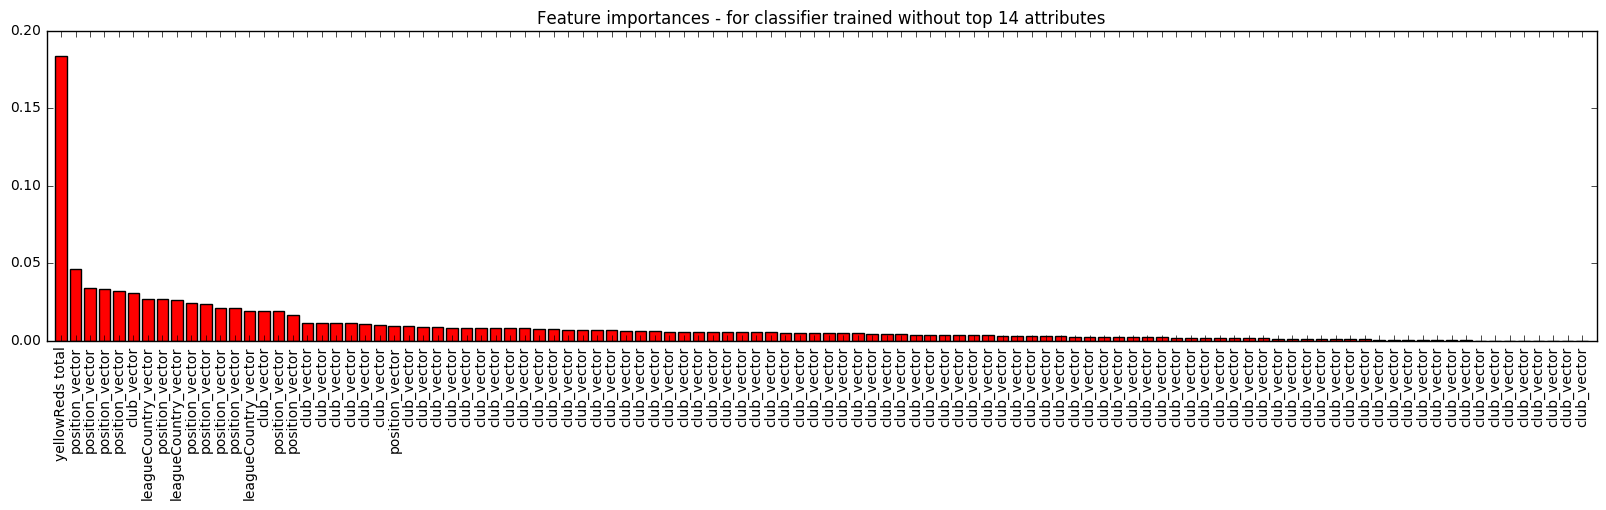

In [57]:
# Delete the top 14 features from data matrix X_final
X = np.delete (X_final,indices[0:14],1)

# these also need to be deleted from the feature_names since we'll use the feature names for plotting next
feature_names_new = np.delete(feature_names, indices[0:14],0)
xlimit=106

# Train with the modified data matrix X
forest = RandomForestClassifier()
forest.fit(X,y.ravel())
importances = forest.feature_importances_
indices_new = np.argsort(importances)[::-1]


plt.rcParams["figure.figsize"] = [20,4]

plt.figure()
plt.title("Feature importances - for classifier trained without top 14 attributes")
plt.bar(range(X.shape[1]), importances[indices_new],
       color="r",  align="center")
plt.xticks(range(xlimit), feature_names_new[indices_new],rotation='vertical')
plt.xlim([-1, xlimit])
plt.show()


This ordering also seems to be pretty similar to the original ordering we had before dropping anything. 
Hence we fail to obtain a substantially different $feature_importances_$ attribute.

## Bonus part

/Users/akhileshgotmare/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/akhileshgotmare/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/akhileshgotmare/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/akhileshgotmare/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/akhileshgotmare/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently

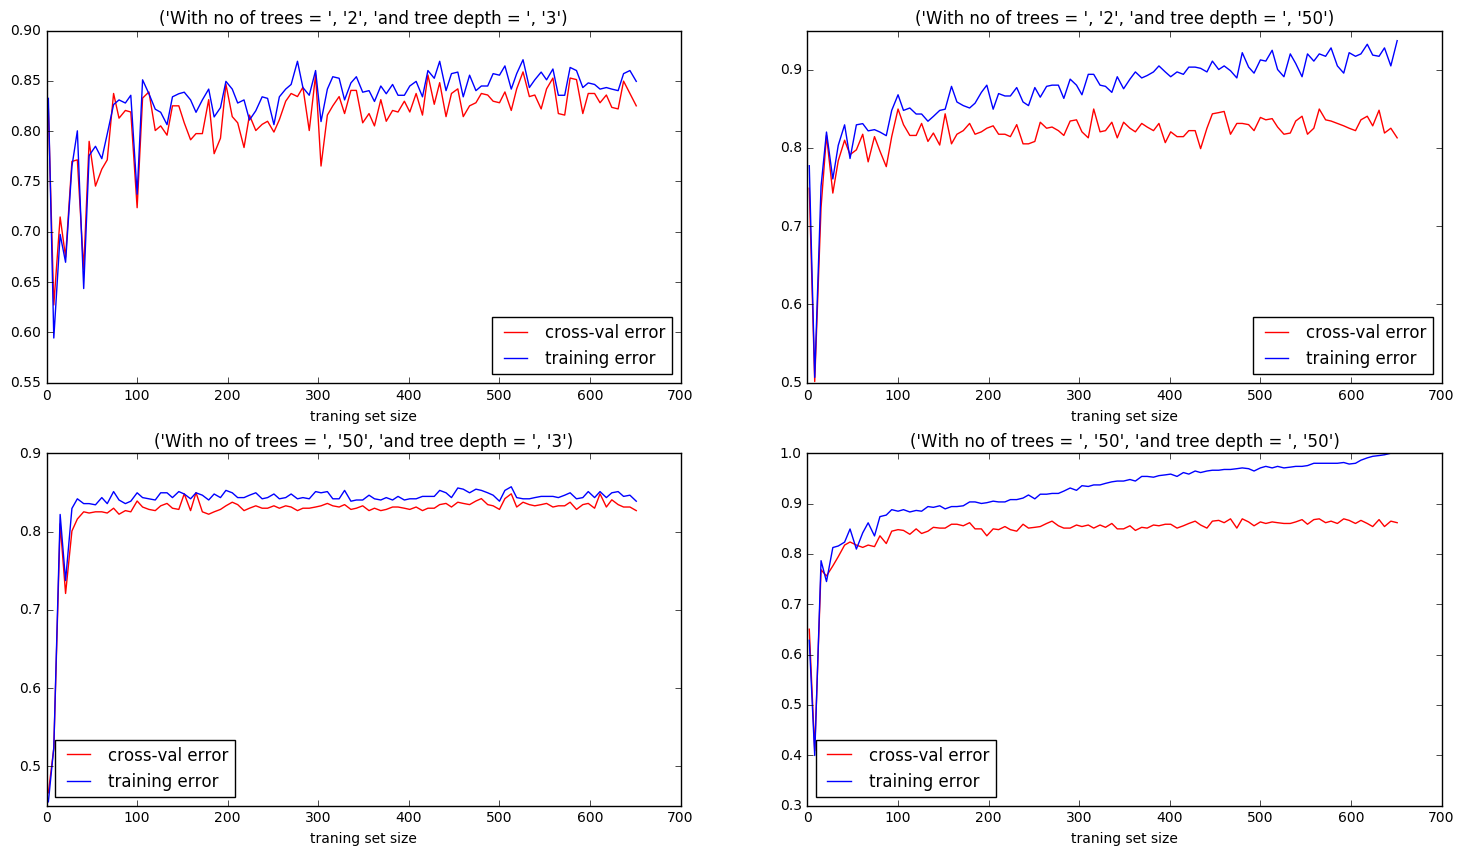

In [58]:
#------------------------------------------------------------
# Plot training error and cross-val error
#   as a function of training set size

plt.rcParams["figure.figsize"] = [18,10]

Ntrain = np.floor(X_final.shape[0]/2)
Ncrossval = np.floor(X_final.shape[0]/2)

np.random.seed(0)
X = X_final
Y = y

xtrain = X[:Ntrain]
ytrain = Y[:Ntrain]

xcrossval = X[Ntrain:]
ycrossval = Y[Ntrain:]

sizes = np.linspace(2, Ntrain, 100).astype(int)
train_err = np.zeros(sizes.shape)
crossval_err = np.zeros(sizes.shape)

[n_est, max_d] = [100, 20] #Setting the hyper-parameters

fig = plt.figure()


count = 1
for n_est in [2,50]:
    for max_d in [3,50]:


        for i, size in enumerate(sizes):

            rfc1 = RandomForestClassifier(n_estimators = n_est, max_depth = max_d)
            rfc1.fit(xtrain[:size],ytrain[:size].ravel())

            #p = np.polyfit(xtrain[:size], ytrain[:size], d)
            crossval_err[i] = rfc1.score(xcrossval, ycrossval.ravel())
            train_err[i] = rfc1.score(xtrain,ytrain.ravel())
        
        ax = fig.add_subplot(220+count)
        ax.plot(sizes, crossval_err, 'r-',label = 'cross-val error')
        ax.plot(sizes, train_err, 'b-',label = 'training error')
        ax.title.set_text(('With no of trees = ',np.str(n_est), 'and tree depth = ',np.str(max_d)))
        ax.set_xlabel('traning set size')
        ax.legend(loc='best')
        ax.get_legend()
        count += 1
fig.show()        

The above plot shows the performance of the classifier for 4 different set of hyper-parameters. The two subplots on the left where the no of estimators = 2 and the depth of the tree is equal to 3 are examples of high bias. The classifier model is just not complex enough to capture the distribution. Hence both the training and test accuracy do not reach the value 1 with additional data available for training.

On the right we have two subplots showing performance of classifiers with depth of the tree equal to 50 for 2 values of no of estimators (2 and 50). The one on bottom right is an example of high variance, since the training accuracy reaches 1 as the data increases, however the test accuracy does not improve in return and stays more or less near 0.8. The reason for this is highly complex classifier leading to over-fitting.

## Excercise 2

Since we have already aggregated the referee information grouping by soccer player, we use unsupervised learning technique K-means++ to cluster the soccer players in 2 disjoint clusters. For a non-standartized version of dataset X_final, we get silhuoette score close to 0.54. Clusters we get are labeled with 0 and 1. We compare those labels with y labels from the Exercise 1, which denote black and white players. We get 0.38 score, which means that the clustering has 38% accuracy in comparison with exact race labels (as far as we do not specify labels that must be assigned to each cluster, it could be also considered as 62% accuracy).

In [59]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
kmeans2 = KMeans(n_clusters=2, init='k-means++', random_state=0)
kmeans2.fit(X_final_ex2)
labels = kmeans2.labels_
print("sil. score: ",silhouette_score(X_final_ex2, labels, metric='euclidean', sample_size=None, random_state=None))
print("race match: ", metrics.accuracy_score(y, labels))

sil. score:  0.544263508091
race match:  0.383729854183


We want to obtain higher results for both of these parameters by changing the combination of features we use to learn our model. We will chose different subsets of features and calculate these parameters in order to find cluster which close enough suit 2 races. According to the first exercise first 12 features are most significant, therefore we will keep only them in further ananlysis. Afterwards, we create all possible subsets of first 12 features. For each subset of features we train new model and calculate silhuoette score and race matching score (how well clusters represent race division). 

In [60]:
X_final_ex2 = X_final_ex2.astype(float)
X_test = np.delete (X_final_ex2, range(12, 120), 1)

In [61]:
kmeans2 = KMeans(n_clusters=2, init='k-means++', random_state=0)
kmeans2.fit(X_test)
labels = kmeans2.labels_
print("sil. score: ",silhouette_score(X_test, labels, metric='euclidean', sample_size=None, random_state=None))
print("race match: ", metrics.accuracy_score(y, labels))

sil. score:  0.544342728543
race match:  0.383729854183


In [62]:
import itertools
def findsubsets(S,m):
    return list(set(itertools.combinations(S, m)))

features_sub=[]
for i in range(11,0,-1): features_sub.append(findsubsets(range(12),i))

In [63]:
sil_score=[]
race_match=[]
for i in range(0,11):
    print (i+1)
    for s in features_sub[i]:
        indices = list(set(range(12)) - set(s))
        X=np.delete(X_test,indices,1)
        kmeans2 = KMeans(n_clusters=2, init='k-means++', random_state=0)
        kmeans2.fit(X)
        labels = kmeans2.labels_
        sil_score.append(silhouette_score(X, labels, metric='euclidean', sample_size=None, random_state=None))
        race_match.append(metrics.accuracy_score(y, labels))

1
2
3
4
5
6
7
8
9
10
11


From all subset we want to find one with maximal race match score where silhuoette score is above 0.7. 

In [64]:
def find_sub(ind):
    i=0
    while len(features_sub[i])<ind: 
        ind=ind-len(features_sub[i])
        i+=1
    return features_sub[i][ind]

In [65]:
sil_sc=0
while True:
    ind = race_match.index(max(race_match))
    sub = find_sub(ind)
    sil_sc = sil_score[ind]
    if sil_sc>0.7: break
    race_match[ind]=0
print("maximal value of race match: ", max(race_match))
print ("subset for which we have maximum race_match value: ", find_sub(ind))
print ("silhuoette score for that subset: ", sil_score[ind])

maximal value of race match:  0.774366845741
subset for which we have maximum race_match value:  (0, 1, 6, 8, 9, 10, 11)
silhuoette score for that subset:  0.722471033266


According to the results we conclude that maximal silhuoette score we can obtain using this range of features is close to 0.72. Maximal race matching is close to 0.77, which means that the clustering has 77% accuracy in comparison with exact race labels. We can obtain this similar score (close to 77%) for different combinations of features. Therefore, in general we can say that according to given information about different parameters of players, we can separate of players in two sets in each of which there is a majority of people with particulat skin color. This means that in general there are some kind of social and historical circumstances and misconsceptions which make possible that black and white players can be clustered. 